# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("drive/My Drive/Colab Notebooks/assignment1")
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
collectSubmission.sh  knn.ipynb		  softmax.ipynb
cs231n		      my_numpy_exo.ipynb  start_ipython_osx.sh
features.ipynb	      README.md		  svm.ipynb
frameworkpython       requirements.txt	  two_layer_net.ipynb


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10

import random
import numpy as np
#from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    #cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    #X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train = X_train - mean_image
    X_val = X_val - mean_image
    X_test = X_test - mean_image
    X_dev = X_dev - mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

170500096/170498071 [==============================] - 4s 0us/step
Train data shape:  (49000, 3073)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 3073)
Test labels shape:  (1000, 1)
dev data shape:  (500, 3073)
dev labels shape:  (500, 1)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.415262
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ 
Basically, our weights are close to zero, so if we compute the loss we roughly get -log(1/C) and here C=10. 




In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.800215 analytic: -1.800215, relative error: 1.176488e-08
numerical: 0.061343 analytic: 0.061343, relative error: 1.074390e-07
numerical: -0.590111 analytic: -0.590111, relative error: 6.246656e-08
numerical: -0.313227 analytic: -0.313227, relative error: 5.986667e-08
numerical: 0.232118 analytic: 0.232118, relative error: 1.623064e-07
numerical: 0.361686 analytic: 0.361686, relative error: 7.994740e-08
numerical: 0.400435 analytic: 0.400434, relative error: 3.932968e-08
numerical: -2.625224 analytic: -2.625224, relative error: 2.175925e-09
numerical: 1.055171 analytic: 1.055171, relative error: 1.971555e-08
numerical: 1.382273 analytic: 1.382273, relative error: 1.343101e-08
numerical: 0.113520 analytic: 0.113520, relative error: 4.452946e-07
numerical: 3.263826 analytic: 3.263825, relative error: 7.642156e-09
numerical: 4.902584 analytic: 4.902584, relative error: 9.193948e-09
numerical: -1.965961 analytic: -1.965961, relative error: 9.820257e-09
numerical: 5.501105 anal

In [12]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.415262e+00 computed in 0.151233s
vectorized loss: 2.415262e+00 computed in 0.014881s
Loss difference: 0.000000
Gradient difference: 0.000000


In [16]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_params = (0,0)
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
num_iters = 10
for lr in np.arange(len(learning_rates)):
  for reg in np.arange(len(regularization_strengths)):
    softmax_clf = Softmax()
    softmax_clf.train(X_train, y_train, learning_rate= lr, 
                      reg=reg, num_iters= 10, verbose =False)
    y_train_pred = softmax_clf.predict(X_train)
    y_val_pred = softmax_clf.predict(X_val)
    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)    
    results[(lr,reg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
      best_val = val_accuracy
      best_params = (lr, reg)

best_softmax = Softmax()
best_softmax.train(X_train, y_train, learning_rate = best_params[0], 
                      reg = best_params[1], num_iters= 10, verbose = False)
    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/drive/My Drive/Colab Notebooks/assignment1/cs231n/classifiers/softmax.py:94: RuntimeWarning: divide by zero encountered in log
  Li = - np.log(probas_yi)


lr 0.000000e+00 reg 0.000000e+00 train accuracy: 0.099981 val accuracy: 0.100424
lr 0.000000e+00 reg 1.000000e+00 train accuracy: 0.100004 val accuracy: 0.098949
lr 1.000000e+00 reg 0.000000e+00 train accuracy: 0.099909 val accuracy: 0.105078
lr 1.000000e+00 reg 1.000000e+00 train accuracy: 0.099841 val accuracy: 0.107978
best validation accuracy achieved during cross-validation: 0.107978


In [17]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.103731


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$

TRUE 

$\color{blue}{\textit Your Explanation:}$

Let's recall the per-datapoint loss (SVM loss) :
$$
L_i = \sum_{j \neq y_i} max(0, s_j - s_{y_i} + 1)
$$
So typically, if you add a new datapoint where its scores are s.t Li = 0 (which is possible due to the marge !), you don't change the overall loss. 

Whereas, the per-datapoint loss (Softmax) is the following :
$$
L_i = - log(\frac{e^{y_i}}{\sum_j e^j})
$$
which is almost never equal to zero. 

This occurs because the SVM loss is local objective, that is, it does not care about the details of individual scores only the margin has to be satisfied. On the other hand, the Softmax classifier considers all the individual scores in the calculation of the loss.

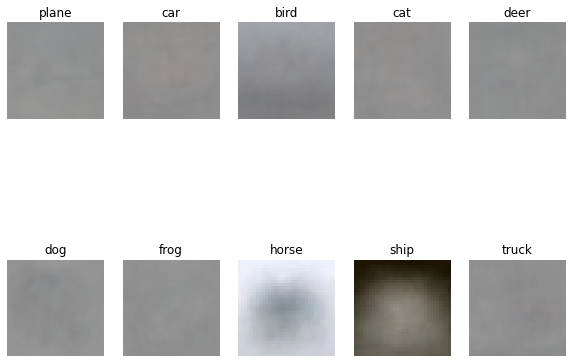

In [18]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])